In [2]:
from transformers import pipeline
from sqlutils import sqlutils
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing
from concurrent.futures import ThreadPoolExecutor

In [3]:
# Déterminer le chemin du script
script_path = Path().resolve()

# # Select des avis depuis la base de données et depuis le chemin du script
bdd = sqlutils(script_path / "../../data/friands.db")
query = f"SELECT avis.*, restaurants.nom FROM avis JOIN restaurants ON avis.id_restaurant = restaurants.id_restaurant"
success, t_avis = bdd.select(query)

if not success:
    print("Erreur lors de l'extraction des avis depuis la base de données")
    print(t_avis)
else:
    print(
        f"Extraction de {len(t_avis)} enregistrements depuis la base de données réussie"
    )

# # Insérer les champs extraits de la base de données dans un dataframe
df = pd.DataFrame(
    t_avis,
    columns=[
        "id_avis",
        "id_restaurant",
        "nom_utilisateur",
        "note_restaurant",
        "date_avis",
        "titre_avis",
        "contenu_avis",
        "label",
        "nom",
    ],
)

Extraction de 4573 enregistrements depuis la base de données réussie


In [4]:
# Création du classifier
classifier = pipeline(
    "sentiment-analysis",
    model="nlptown/bert-base-multilingual-uncased-sentiment",
    tokenizer="nlptown/bert-base-multilingual-uncased-sentiment",
)

Device set to use cpu


In [5]:
# Fonction de traitement des avis
def process_review(review):
    # Appliquer le classifier sur les 1500 premiers caractères de l'avis
    res = classifier(review[:1500])
    # Retourner le label et le score
    return res[0]["label"], res[0]["score"]


## Sans multi-threading
# start_time = time.time()
# results = [process_review(review) for review in df["contenu_avis"]]
# df[["label", "score"]] = pd.DataFrame(results)
# end_time = time.time()
# print(f"Temps d'exécution: {end_time - start_time:.2f} secondes")

## Avec multi-threading
n_jobs = multiprocessing.cpu_count()
# start_time = time.time()
with ThreadPoolExecutor(max_workers=n_jobs) as executor:
    results = executor.map(process_review, df["contenu_avis"])
df[["label", "score"]] = pd.DataFrame(results)
# end_time = time.time()
# print(f"Temps d'exécution: {end_time - start_time:.2f} secondes")

# Temps d'exécution sans puis avec multi-threading :
# Temps d'exécution: 499.09 secondes
# Temps d'exécution: 307.96 secondes

# Graphiques

Répartition des notes des internautes, et prédites à l'aide des commentaires.

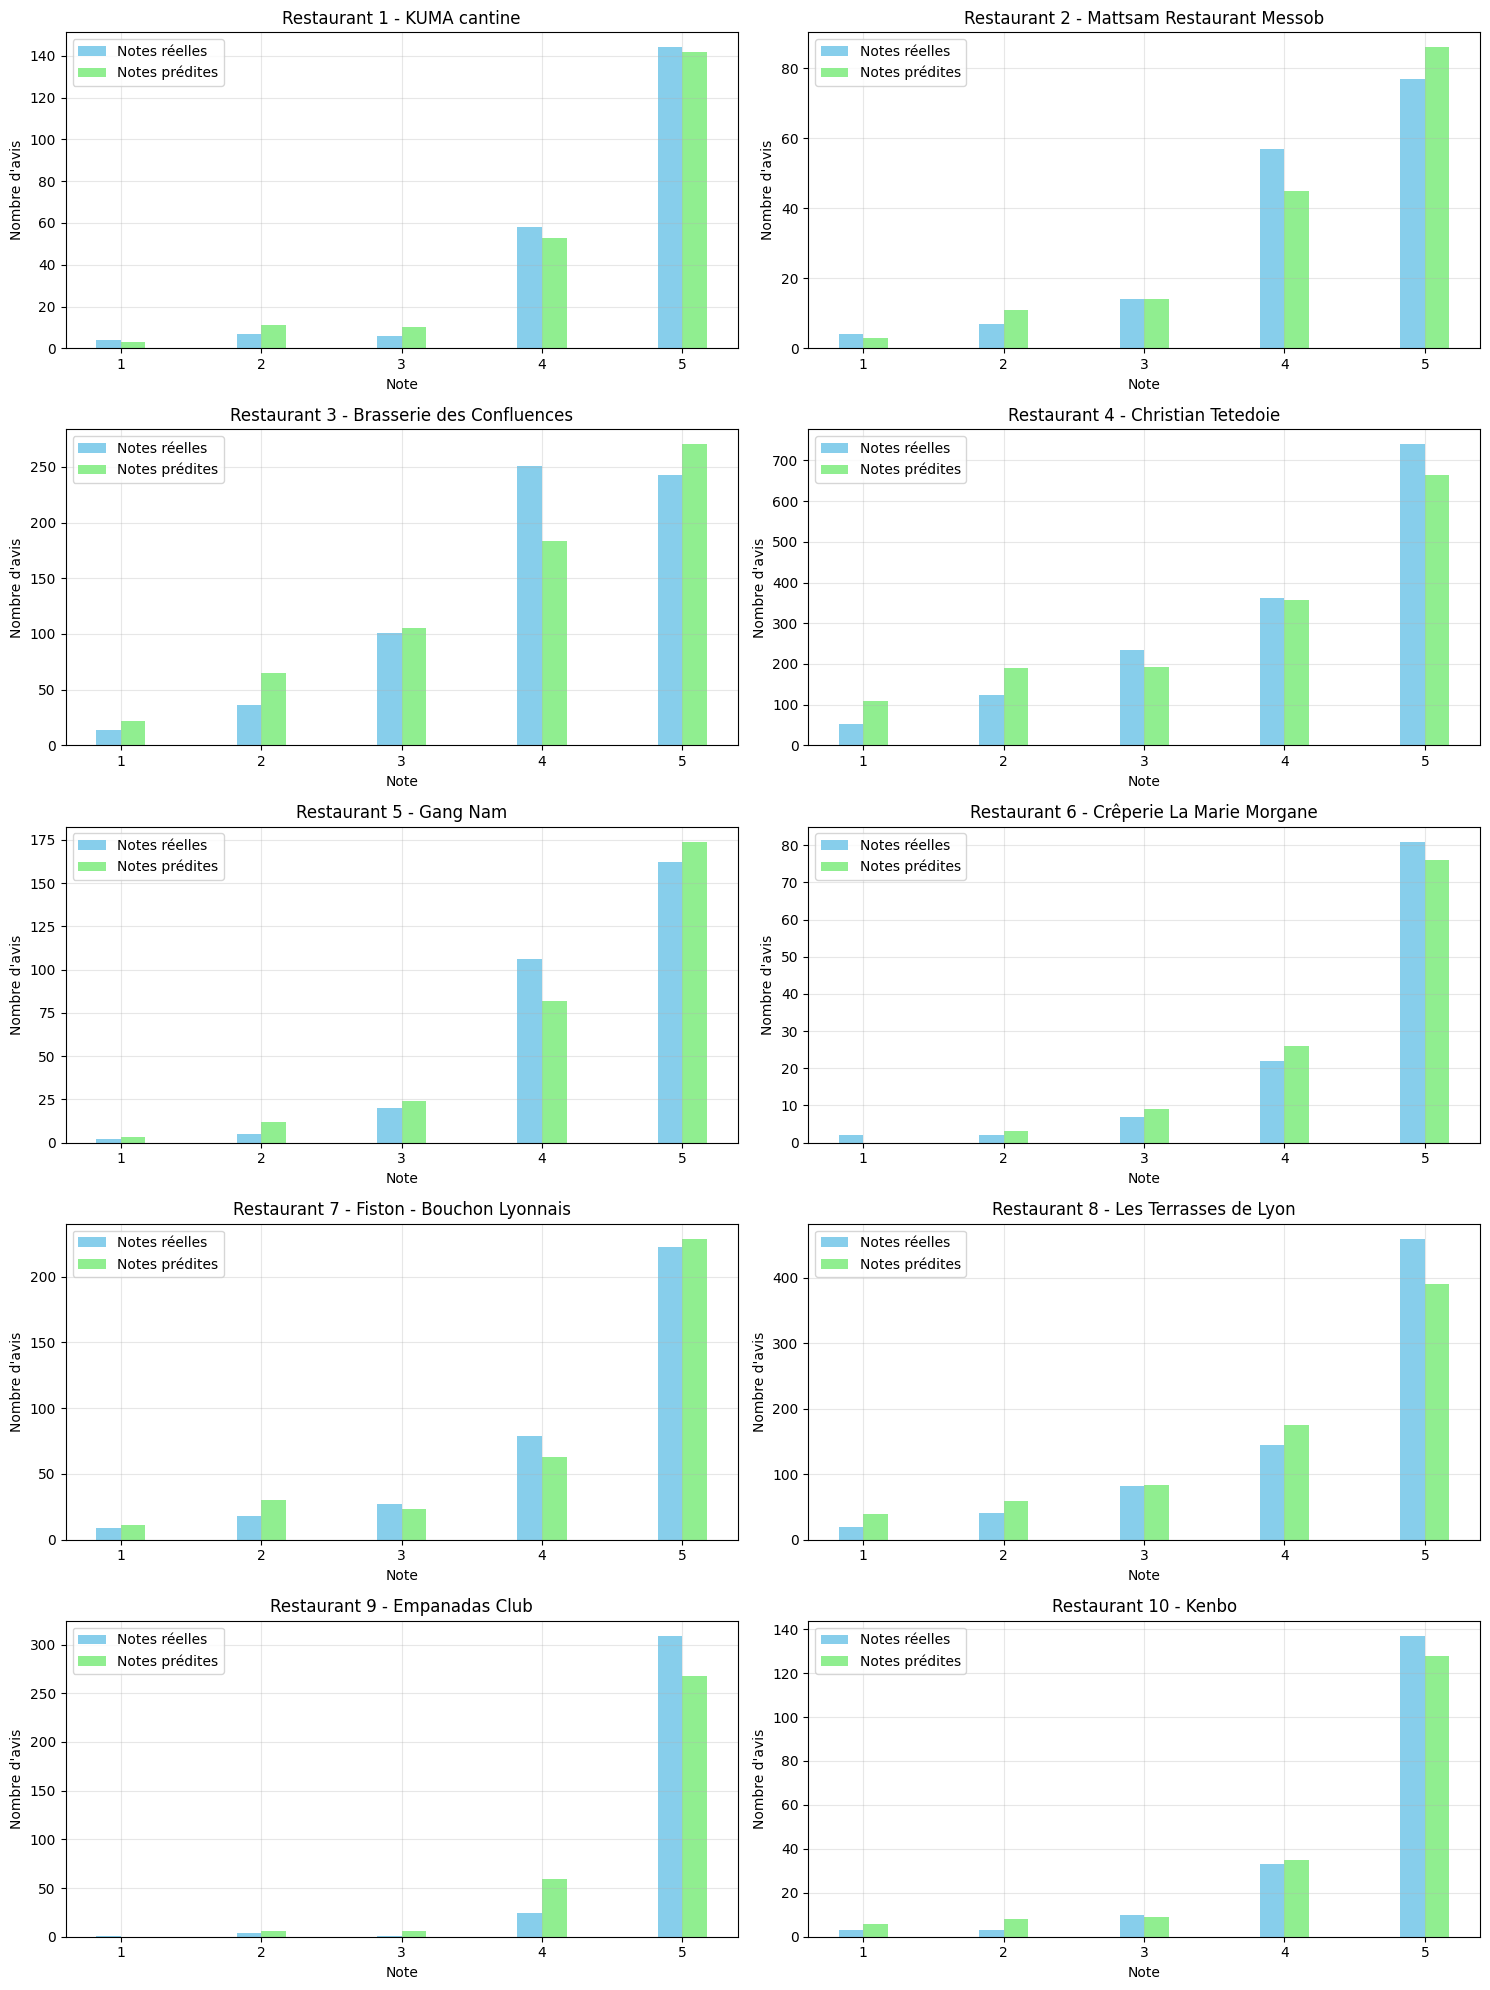

In [6]:
# Calculate number of restaurants and determine subplot layout
unique_restaurants = df["id_restaurant"].unique()
n_restaurants = len(unique_restaurants)
n_cols = 2
n_rows = (
    n_restaurants + n_cols - 1
) // n_cols  # Ceiling division to ensure all plots fit

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

# Create histogram for each restaurant
for idx, restaurant_id in enumerate(unique_restaurants):
    restaurant_data = df[df["id_restaurant"] == restaurant_id]

    # Convert labels to numeric values (1-5 stars)
    label_to_numeric = {
        "1 star": 1,
        "2 stars": 2,
        "3 stars": 3,
        "4 stars": 4,
        "5 stars": 5,
    }
    predicted_ratings = restaurant_data["label"].map(lambda x: label_to_numeric[x])
    actual_ratings = restaurant_data["note_restaurant"]

    # Set width for bars
    width = 0.35

    # Create grouped bars
    axes[idx].hist(
        [actual_ratings, predicted_ratings],
        bins=5,
        range=(0.5, 5.5),
        label=["Notes réelles", "Notes prédites"],
        rwidth=width,
        align="mid",
        color=["skyblue", "lightgreen"],
    )

    restaurant_name = df[df["id_restaurant"] == restaurant_id]["nom"].iloc[0]
    axes[idx].set_title(f"Restaurant {restaurant_id} - {restaurant_name}")
    axes[idx].set_xlabel("Note")
    axes[idx].set_ylabel("Nombre d'avis")
    axes[idx].set_xticks([1, 2, 3, 4, 5])
    axes[idx].grid(True, alpha=0.3)
    axes[idx].legend()

# Remove empty subplots if any
for idx in range(n_restaurants, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

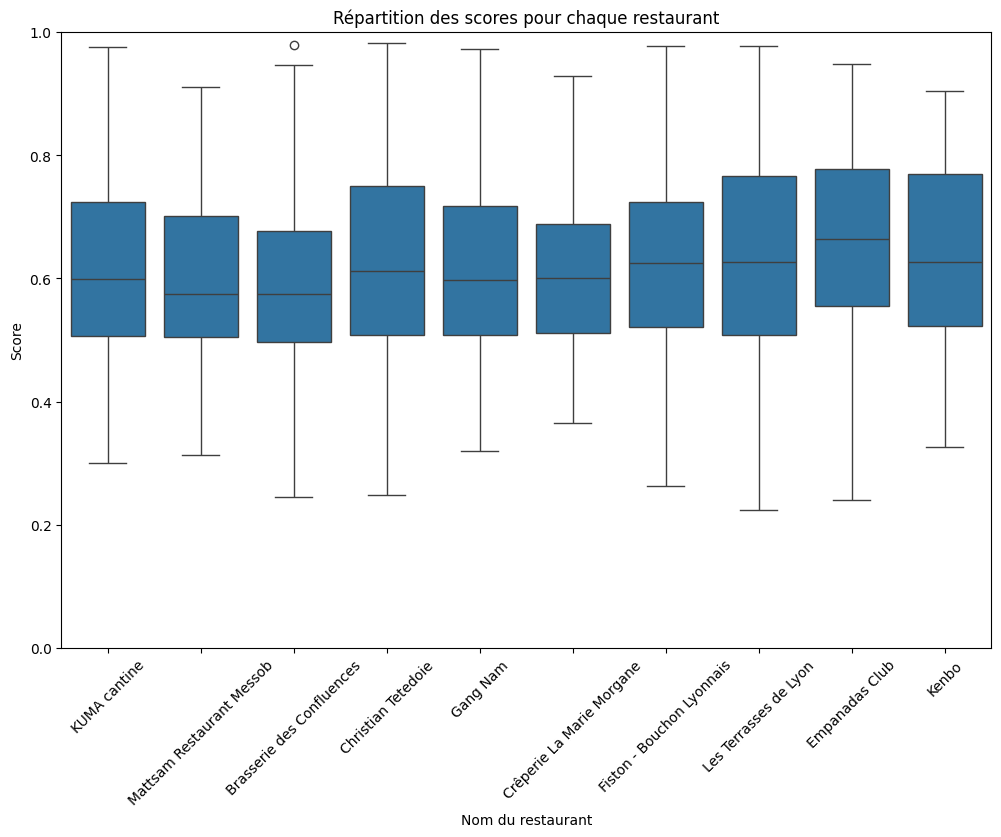

In [7]:
# Create a boxplot for the scores of each restaurant
plt.figure(figsize=(12, 8))
sns.boxplot(x="nom", y="score", data=df)
plt.title("Répartition des scores pour chaque restaurant")
plt.xlabel("Nom du restaurant")
plt.ylabel("Score")
plt.ylim(0, 1)  # Set y-axis limits from 0 to 1
plt.xticks(rotation=45)
plt.show()

### Insérer les labels calculés dans la base de données

In [8]:
# Updater les résumés dans la base de données
for index, row in df.iterrows():
    success, t_insert = bdd.update(
        table_name="avis",
        data={"label": row["label"].split()[0]},
        where=[f"id_avis = '{row['id_avis']}'"],
    )

    if not success:
        bdd.rollback()
        print(f"Erreur lors de la mise à jour du label {row['id_avis']} : {t_insert}")
        print(t_insert)
    else:
        bdd.commit()
        print(f"Label inséré pour l'avis {row['id_avis']} ({t_insert})")

Label inséré pour l'avis 1 (1 row(s) successfully updated)
Label inséré pour l'avis 2 (1 row(s) successfully updated)
Label inséré pour l'avis 3 (1 row(s) successfully updated)
Label inséré pour l'avis 4 (1 row(s) successfully updated)
Label inséré pour l'avis 5 (1 row(s) successfully updated)
Label inséré pour l'avis 6 (1 row(s) successfully updated)
Label inséré pour l'avis 7 (1 row(s) successfully updated)
Label inséré pour l'avis 8 (1 row(s) successfully updated)
Label inséré pour l'avis 9 (1 row(s) successfully updated)
Label inséré pour l'avis 10 (1 row(s) successfully updated)
Label inséré pour l'avis 11 (1 row(s) successfully updated)
Label inséré pour l'avis 12 (1 row(s) successfully updated)
Label inséré pour l'avis 13 (1 row(s) successfully updated)
Label inséré pour l'avis 14 (1 row(s) successfully updated)
Label inséré pour l'avis 15 (1 row(s) successfully updated)
Label inséré pour l'avis 16 (1 row(s) successfully updated)
Label inséré pour l'avis 17 (1 row(s) successfull